In [1]:
!pip install --upgrade torch | tail -n 1

In [2]:
!pip install --upgrade tensorboard | tail -n 1

In [227]:
import torch 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
tqdm.pandas()

In [272]:
# #standarised and encode columns
# category_cols = ['breed']
# numerical_cols = ['hair_length','height','num_vet_visit','weight']

# transformer = make_pipeline(
#     ColumnTransformer([
#         ('num', StandardScaler(), numerical_cols),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), category_cols),    
#     ])
# ) 

def load_data(filepath):
    
    columns = ['index','age','breed','last_vet_visit','hair_length','height','num_vet_visit','weight']
    
    return pd.read_csv(filepath,names=columns,header=0)

def remove_negative_value(df, columns):
    # df: dataframe of the data 
    # columns: list of columns need to remove negative value from 
    
    if len(columns) == 0 and df.empty:
        return df
    
    for col in columns:
        df = df[df[col]>=0]
    
    return df


def remove_extreme_outliers(df,columns):
    #for values great then quantile 99.9% then it would be treated as exterm outlier 
    # df: dataframe of the data 
    # columns: list of columns need to remove negative value from 
    
    if len(columns) == 0 and df.empty:
        return df
    
    for col in columns:
        limit = df[col].quantile(0.999)
        df = df[df[col]<limit] 
        
    return df


def preprocess():
    
    filepath='data.csv'

    df = load_data(filepath)

    #remove  column 
    df = df.drop(columns=['index','last_vet_visit'])

    #remove any negative value
    df = remove_negative_value(df,['age','hair_length','height','num_vet_visit','weight'])

    #remove any exterme outliers
    df = remove_extreme_outliers(df,['age','hair_length','height','num_vet_visit','weight'])
    
    
#     transformed = transformer.fit_transform(df)

    
    
    #split training, test and validation set
    val_size = 0.15 
    test_size = 0.15
    
    df_temp,df_test = train_test_split(df, test_size=test_size,random_state=1)
    df_train,df_val = train_test_split(df_temp, test_size=val_size,random_state=1)
    
    return df_train,df_test,df_val

In [273]:
train,test,val=preprocess()
print('train size {}, test size {}, validation size {}'.format(train.shape,test.shape,val.shape))

train size (209, 6), test size (44, 6), validation size (37, 6)


In [274]:
#Dataset class
class CatDataset(torch.utils.data.Dataset):
    
    category_cols = ['breed']
    numerical_cols = ['hair_length','height','num_vet_visit','weight']


    def initTransformer(self):
        return make_pipeline(
            ColumnTransformer([
                ('num', StandardScaler(), numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), category_cols),    
            ])
        )
        
    def get_transformer(self):
        return self.transformer
    
    def __init__(self, df, transformer=None):
        #self.labels = labels
        #self.list_IDs = list_IDs
        super().__init__()
        self.df = df
        
        if transformer is None:
            self.transformer = self.initTransformer()
            self.transformer.fit(df)
        else:
            self.transformer = transformer

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):

        # Load data and get label
#         print(self.df.iloc[[index]]['age'].values)
        y = torch.tensor(self.df.iloc[[index]]['age'].values,dtype=torch.float32)
#         print(self.transformer.transform(self.df.iloc[[index]].drop(columns=['age'])))
        X = torch.tensor(self.transformer.transform(self.df.iloc[[index]].drop(columns=['age'])),dtype=torch.float32)
        

        return X, y

In [375]:
trainDS = CatDataset(train)
transformer = trainDS.get_transformer()
testDS = CatDataset(test,transformer)
valDS = CatDataset(val,transformer)

# Parameters
params = {'batch_size': 4,
          'shuffle': True,
          'drop_last': True}

trainDL = DataLoader(trainDS, **params)

testDL = DataLoader(testDS)
valDL = DataLoader(valDS)

print(len(trainDL), len(testDL), len(valDL))

52 44 37


In [376]:
X, y = next(iter(valDL))
# print(X)
print(X.shape)

torch.Size([1, 1, 10])


In [410]:
# Model Class
# Fully connected neural network with three hidden layer
class FeedForward(nn.Module):
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)    
    
    def __init__(self, input_size):
        super().__init__()
        
        self.net = nn.Sequential(
            
            nn.Linear(input_size, 20), 
            nn.ReLU(),
            nn.BatchNorm1d(20),
#             nn.Dropout(),
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
#             nn.Dropout(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
#             nn.Dropout(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),            
#             nn.Dropout(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),            
#             nn.Dropout(),            
            nn.Linear(20, 1)
        )
        
        self.net.apply(self.init_weights)
    
    def forward(self, X):
        return self.net(X)
    
    def predict(self, X):
        Y_pred = self.forward(X)
        return Y_pred

In [411]:
# Network params
X, y = next(iter(trainDL))

input_size = X.shape[2]
# drop_out = 0.3
# weight_decay = 0.001
# batch_size = 4

# size of hidden layers
# learning_rate = 0.001

# Early Stop parameters
n_epochs_stop = 4
epochs = 100

In [384]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FeedForward(input_size).to(device)

loss_fn = torch.nn.MSELoss()

# optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
optimiser = torch.optim.AdamW(model.parameters())

In [385]:
print(model)


FeedForward(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=50, out_features=20, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=20, out_features=20, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [386]:
def mean(l):
    return sum(l)/len(l)

epochs = 100

results = []
losses = {'epoch':[], 'training':[],'validation':[]}
min_val_loss = 100
epochs_no_improve = 0


for i in range(epochs):
    loss_t = []
    model = model.train()
    
#     model.hidden = model.init_hidden()
    t = tqdm(iter(trainDL), total=len(trainDL),desc='Training Progress')
    for  itercount, (X, y) in enumerate(t):
#     for  X, y in train_dataloader:
#         X, y = X.to(device), y.to(device)
        optimiser.zero_grad()
#         model.hidden = model.init_hidden()

        X = X.view(-1,input_size)
        y_pred = model(X)


        single_loss = loss_fn(y_pred, y)
        single_loss.backward()
        optimiser.step()
        
        loss_t.append(single_loss.item()) 

    
    print('epoch: {}, Training average loss: {}'.format(i,mean(loss_t)))

    
    #evaluate model every epoch
    model = model.eval()

    loss_v = []
    with torch.no_grad():
        for X,y in valDL:
            X, y = X.to(device), y.to(device)
            X = X.view(-1,input_size)
            y_pred = model(X)
            single_loss = loss_fn(y_pred,y)
            loss_v.append(single_loss.item())
#         results = [y,y_pred]

    print('           Validation average loss: {}'.format(mean(loss_v)))
    
    

    
    #store loss value
    losses['epoch'].append(i)
    losses['training'].append(mean(loss_t))
    losses['validation'].append(mean(loss_v))
    
    #check early stop
    if mean(loss_v) > min_val_loss:
        epochs_no_improve += 1
    else:
        min_val_loss = mean(loss_v)
        epochs_no_improve = 0
        
    print('           Minimum Validation loss: {}'.format(min_val_loss))
        
        
    if epochs_no_improve >= n_epochs_stop:
        print('           Early Stop!!!!! After {} epochs validation loss not improving '.format(epochs_no_improve))
        break
    

#run blindTest set to get result
model = model.eval()
loss_bt = []

with torch.no_grad():
    for X,y in testDL:
        X, y = X.to(device), y.to(device)
        X = X.view(-1,input_size)
        y_pred = model(X)
        single_loss = loss_fn(y_pred,y)
        loss_bt.append(single_loss.item())
        results = [y,y_pred]
#         print(y,y_pred)
        
    
print('BlindTest loss: {}'.format(mean(loss_bt)))


epoch: 0, Training average loss: 90.33478604830228
           Validation average loss: 64.41175218530603
           Minimum Validation loss: 64.41175218530603



epoch: 1, Training average loss: 84.97130188575157
           Validation average loss: 62.78866764661428
           Minimum Validation loss: 62.78866764661428



epoch: 2, Training average loss: 77.88855673716618
           Validation average loss: 57.06248365866171
           Minimum Validation loss: 57.06248365866171



epoch: 3, Training average loss: 70.82628191434421
           Validation average loss: 47.56355919709077
           Minimum Validation loss: 47.56355919709077



epoch: 4, Training average loss: 61.63520321479211
           Validation average loss: 41.27000631240977
           Minimum Validation loss: 41.27000631240977



epoch: 5, Training average loss: 51.972349607027496
           Validation average loss: 32.86344687197659
           Minimum Validation loss: 32.86344687197659



epoch: 6, Training average loss: 42.11370244392982
           Validation average loss: 22.778428209794534
           Minimum Validation loss: 22.778428209794534



epoch: 7, Training average loss: 32.25025667823278
           Validation average loss: 19.80944683976673
           Minimum Validation loss: 19.80944683976673



epoch: 8, Training average loss: 24.345980428732357
           Validation average loss: 13.377848624931397
           Minimum Validation loss: 13.377848624931397



epoch: 9, Training average loss: 19.236854805396153
           Validation average loss: 10.973643019784012
           Minimum Validation loss: 10.973643019784012



epoch: 10, Training average loss: 14.531195069734867
           Validation average loss: 8.421709440246214
           Minimum Validation loss: 8.421709440246214



epoch: 11, Training average loss: 12.194685518741608
           Validation average loss: 7.626471651938266
           Minimum Validation loss: 7.626471651938266



epoch: 12, Training average loss: 10.522196549635668
           Validation average loss: 7.91366369867496
           Minimum Validation loss: 7.626471651938266



epoch: 13, Training average loss: 9.491260072359673
           Validation average loss: 7.8701859721630765
           Minimum Validation loss: 7.626471651938266



epoch: 14, Training average loss: 9.70624220944368
           Validation average loss: 7.1604152609896214
           Minimum Validation loss: 7.1604152609896214



epoch: 15, Training average loss: 10.604691706024683
           Validation average loss: 6.792341632491632
           Minimum Validation loss: 6.792341632491632



epoch: 16, Training average loss: 8.555456809126413
           Validation average loss: 8.375112926436437
           Minimum Validation loss: 6.792341632491632



epoch: 17, Training average loss: 9.50439665867732
           Validation average loss: 7.452732675144059
           Minimum Validation loss: 6.792341632491632



epoch: 18, Training average loss: 9.565552661052116
           Validation average loss: 7.199851247809224
           Minimum Validation loss: 6.792341632491632



epoch: 19, Training average loss: 9.096251373107616
           Validation average loss: 7.9397434644602445
           Minimum Validation loss: 6.792341632491632
           Early Stop!!!!! After 4 epochs validation loss not improving 
BlindTest loss: 9.651262426240878


<AxesSubplot:xlabel='epoch'>

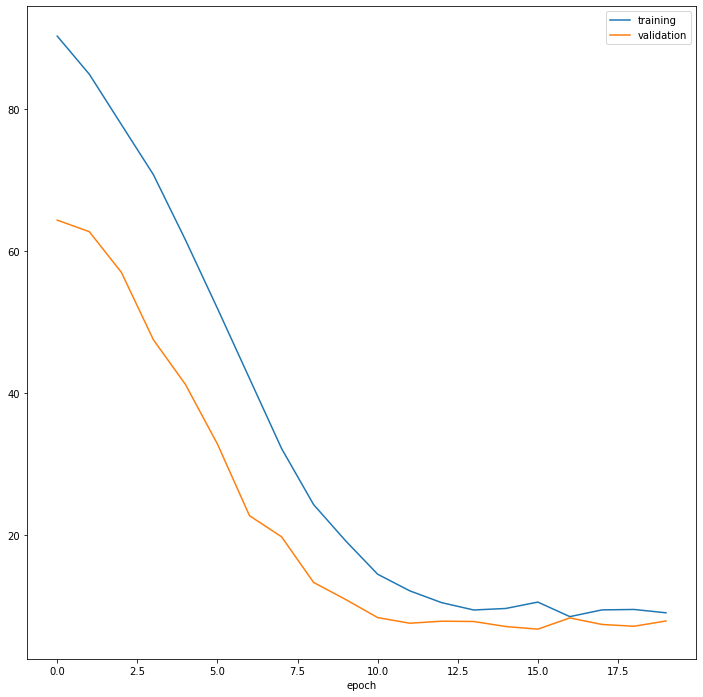

In [387]:
#visualize training loss
losses_df = pd.DataFrame(data=losses)

losses_df.set_index('epoch').plot()

In [388]:
## save model

from joblib import dump, load
transformer = trainDS.get_transformer()
dump(transformer,'transformer_torch.joblib')


torch.save(model, 'torchmodel')